In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text, plot_tree
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import statsmodels.api as sm
# from causalml.metrics import qini_score

In [2]:
sepsis_data = pd.read_csv('dataset/sepsis_dataset.csv')

In [3]:
X = sepsis_data.drop(columns=['survival'])
y = sepsis_data['survival']

SRF

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123)
rf.fit(X_train, y_train)

# T = realtreatment
Twin_1 = rf.predict_proba(X_test)[:, 1]

# switch treatment
X_test_counterfactual = X_test.copy()
X_test_counterfactual['THERAPY'] = 1 - X_test_counterfactual['THERAPY']

# T = theothertreatment
Twin_2 = rf.predict_proba(X_test_counterfactual)[:, 1]

# ITE
SRF_ITE = np.where(X_test['THERAPY'] == 1, Twin_1 - Twin_2, Twin_2 - Twin_1)

DRF

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_trt1 = X_train[X_train['THERAPY'] == 1]
y_train_trt1 = y_train[X_train['THERAPY'] == 1]
X_train_trt0 = X_train[X_train['THERAPY'] == 0]
y_train_trt0 = y_train[X_train['THERAPY'] == 0]
X_test_trt1 = X_test[X_test['THERAPY'] == 1]
X_test_trt0 = X_test[X_test['THERAPY'] == 0]

model_trt1 = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123)
model_trt1.fit(X_train_trt1, y_train_trt1)

model_trt0 = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123)
model_trt0.fit(X_train_trt0, y_train_trt0)

# Compute Twin 1
twin1_scores = np.zeros(len(X_test))

# Fill in the scores based on the original index
twin1_scores[X_test['THERAPY'] == 1] = model_trt1.predict_proba(X_test_trt1)[:, 1]
twin1_scores[X_test['THERAPY'] == 0] = model_trt0.predict_proba(X_test_trt0)[:, 1]

# Compute Twin 2
twin2_scores = np.zeros(len(X_test))

# CROSS OVER: Feed X_1 into rf0, and X_0 into rf1
twin2_scores[X_test['THERAPY'] == 1] = model_trt0.predict_proba(X_test_trt1)[:, 1]
twin2_scores[X_test['THERAPY'] == 0] = model_trt1.predict_proba(X_test_trt0)[:, 1]

DRF_ITE = np.zeros(len(X_test))

# For the Treated group (T=1):
#   P(Y=1|T=1) is Twin 1 (Factual)
#   P(Y=1|T=0) is Twin 2 (Counterfactual)
DRF_ITE[X_test['THERAPY'] == 1] = twin1_scores[X_test['THERAPY'] == 1] - twin2_scores[X_test['THERAPY'] == 1]

# For the Control group (T=0):
#   P(Y=1|T=1) is Twin 2 (Counterfactual)
#   P(Y=1|T=0) is Twin 1 (Factual)
DRF_ITE[X_test['THERAPY'] == 0] = twin2_scores[X_test['THERAPY'] == 0] - twin1_scores[X_test['THERAPY'] == 0]

K FOLD

In [49]:
def compute_kfold_single_rf(X, y, T, treatment_col_name='THERAPY', k=3):
    
    p1_cv = np.zeros(len(X))
    p0_cv = np.zeros(len(X))
    
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=123)
    
    for fold_i, (train_index, val_index) in enumerate(kf.split(X, T)):
        
        X_train_fold = X.iloc[train_index].copy()
        y_train_fold = y.iloc[train_index]
        T_train_fold = T.iloc[train_index]
        
    
        X_train_fold[treatment_col_name] = T_train_fold
        
        rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123)
        rf.fit(X_train_fold, y_train_fold)
        
        X_val_fold = X.iloc[val_index]
        
        X_val_forced_1 = X_val_fold.copy()
        X_val_forced_1[treatment_col_name] = 1
       
        X_val_forced_0 = X_val_fold.copy()
        X_val_forced_0[treatment_col_name] = 0
        
        p1_probs = rf.predict_proba(X_val_forced_1)[:, 1]
        p0_probs = rf.predict_proba(X_val_forced_0)[:, 1]
        
        
        p1_cv[val_index] = p1_probs
        p0_cv[val_index] = p0_probs

    
    ite_cv = p1_cv - p0_cv
    
    return p1_cv, p0_cv, ite_cv


P1_vec, P0_vec, KF_ITE = compute_kfold_single_rf(
    X, 
    y, 
    sepsis_data['THERAPY'], 
    treatment_col_name='THERAPY', 
    k=3
)


Evaluations

In [59]:
# Single Random Forest
y_test_pos = y_test.reset_index(drop=True)

treated_idx = np.where(X_test['THERAPY'].to_numpy() == 1)[0]
control_idx = np.where(X_test['THERAPY'].to_numpy() == 0)[0]

treated_features = np.column_stack((Twin_1[treated_idx], Twin_2[treated_idx]))
control_features = np.column_stack((Twin_1[control_idx], Twin_2[control_idx]))

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_features)
distances, matched_idx = nn.kneighbors(treated_features)

matched_control_idx = control_idx[matched_idx.flatten()]

pseudo_ITE_SRF = y_test_pos.iloc[treated_idx].to_numpy() - y_test_pos.iloc[matched_control_idx].to_numpy()

linear_reg_SRF = sm.add_constant(SRF_ITE[treated_idx])
model = sm.OLS(pseudo_ITE_SRF, linear_reg_SRF)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     45.86
Date:                Mon, 05 Jan 2026   Prob (F-statistic):           9.80e-10
Time:                        11:33:57   Log-Likelihood:                -88.390
No. Observations:                  99   AIC:                             180.8
Df Residuals:                      97   BIC:                             186.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0398      0.061      0.654      0.5

In [60]:
#Double Random Forest

treated_features = np.column_stack((twin1_scores[treated_idx], twin2_scores[treated_idx]))
control_features = np.column_stack((twin1_scores[control_idx], twin2_scores[control_idx]))

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_features)
distances, matched_idx = nn.kneighbors(treated_features)

matched_control_idx = control_idx[matched_idx.flatten()]

pseudo_ITE_DRF = y_test_pos.iloc[treated_idx].to_numpy() - y_test_pos.iloc[matched_control_idx].to_numpy()

linear_reg_DRF = sm.add_constant(DRF_ITE[treated_idx])
model = sm.OLS(pseudo_ITE_DRF, linear_reg_DRF)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     58.95
Date:                Mon, 05 Jan 2026   Prob (F-statistic):           1.29e-11
Time:                        11:34:00   Log-Likelihood:                -90.471
No. Observations:                  99   AIC:                             184.9
Df Residuals:                      97   BIC:                             190.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0448      0.062      0.725      0.4

In [50]:
#Kfold

nn = NearestNeighbors(n_neighbors=1).fit(control_features)
distances, matched_idx = nn.kneighbors(treated_features)
matched_control_idx = control_idx[matched_idx.flatten()]

pseudo_ITE_KF = y.iloc[treated_idx].to_numpy() - y.iloc[matched_control_idx].to_numpy()

pred_ITE_treated = KF_ITE[treated_idx]

observed_direction = (pseudo_ITE_KF > 0).astype(int)
predicted_direction = (pred_ITE_treated > 0).astype(int)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(observed_direction, predicted_direction)

print(f"K-Fold Consistency Accuracy (Treated Only): {accuracy:.4f}")

K-Fold Consistency Accuracy (Treated Only): 0.5859


In [68]:
def calculate_qini_normalized(y_true, treatment, ite_pred):
    df = pd.DataFrame({
        'y': y_true,
        't': treatment,
        'ite': ite_pred
    })
    df = df.sort_values('ite', ascending=False).reset_index(drop=True)
    
    df['n_t'] = df['t'].cumsum()
    df['n_c'] = (1 - df['t']).cumsum()
    df['y_t'] = (df['y'] * df['t']).cumsum()
    df['y_c'] = (df['y'] * (1 - df['t'])).cumsum()
    
    n_c_safe = df['n_c'].replace(0, 1)
    df['qini_curve'] = df['y_t'] - (df['y_c'] * df['n_t'] / n_c_safe)
    
    actual_auc = np.trapz(df['qini_curve'])
    final_qini_val = df['qini_curve'].iloc[-1]
    random_auc = (final_qini_val * len(df)) / 2
    qini_score = (actual_auc - random_auc) / len(df)
    
    return qini_score

normalized_kfold_qini = calculate_qini_normalized(y, sepsis_data['THERAPY'], KF_ITE)

print(f"Normalized K-Fold Qini Score: {normalized_kfold_qini:.4f}")

Normalized K-Fold Qini Score: 13.7735


C:\Users\jewel\AppData\Local\Temp\ipykernel_28324\3831361784.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  actual_auc = np.trapz(df['qini_curve'])


In [51]:
X_reg = sm.add_constant(pred_ITE_treated) 

# Ensure pseudo_ITE_KF and pred_ITE_treated are same length
model = sm.OLS(pseudo_ITE_KF, X_reg)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     8.671
Date:                Mon, 05 Jan 2026   Prob (F-statistic):            0.00405
Time:                        01:27:55   Log-Likelihood:                -100.03
No. Observations:                  99   AIC:                             204.1
Df Residuals:                      97   BIC:                             209.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1278      0.071     -1.795      0.0

Qini

not included in prev methods

Classification Accuracy (Consistency with Pseudo-ITE): 0.7475


C:\Users\jewel\AppData\Local\Temp\ipykernel_28324\3396397234.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auqc = np.trapz(qini_curve, x_axis) - np.trapz(random_curve, x_axis)


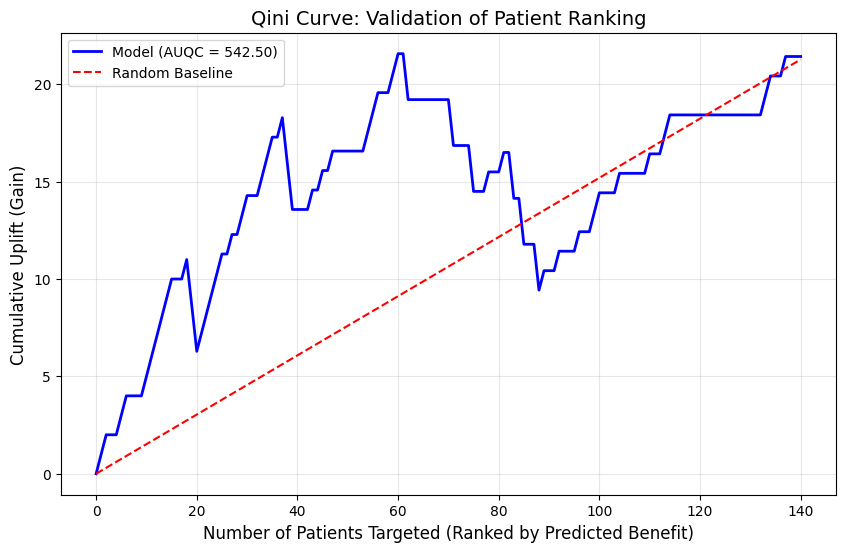

Qini Score (AUQC): 542.50

--- Standardized Mean Difference (SMD) ---
    Variable       SMD
0   PRAPACHE  0.039790
1        AGE  0.066804
2      BLGCS  0.012890
3   ORGANNUM  0.134399
4      BLIL6  0.111211
5    BLLPLAT  0.223479
6    BLLBILI  0.011982
7   BLLCREAT  0.027182
8   TIMFIRST  0.109385
9      BLADL  0.062507
10    blSOFA  0.210072


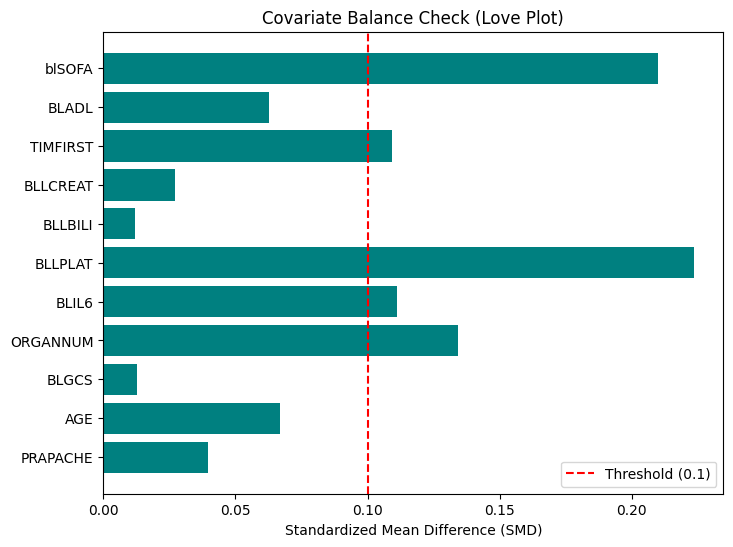

c:\Users\jewel\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


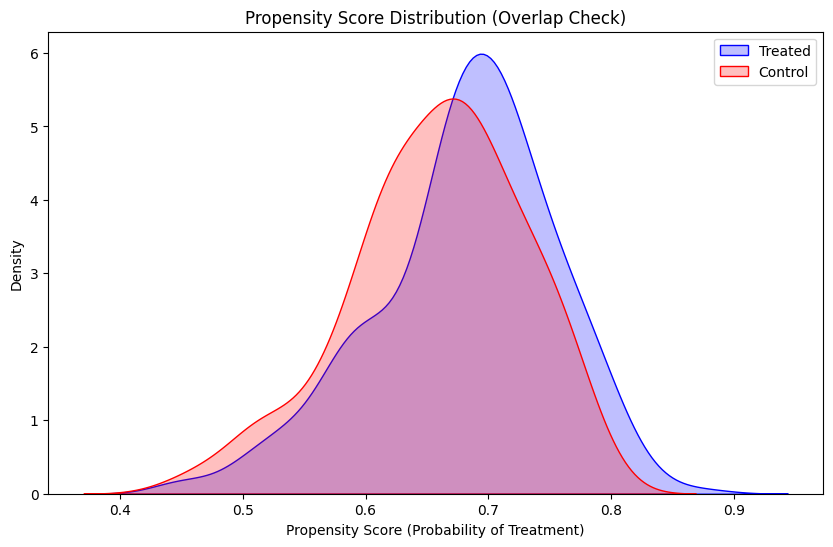

In [54]:
#1. Accuracy
treated_mask = (X_test['THERAPY'] == 1)
model_ite_treated = DRF_ITE[treated_mask]

pred_direction = (model_ite_treated > 0).astype(int)
observed_direction = (pseudo_ITE_DRF > 0).astype(int)

accuracy = accuracy_score(observed_direction, pred_direction)
print(f"Classification Accuracy (Consistency with Pseudo-ITE): {accuracy:.4f}")

# 2. QINI CURVE & SCORE (Ranking)
def qini_rank(uplift_score, y_true, treatment, plot=True):
    results = pd.DataFrame({
        'y': y_true,
        'w': treatment,
        'uplift': uplift_score
    })
    results = results.sort_values(by='uplift', ascending=False).reset_index(drop=True)
    N_t = results[results['w'] == 1].shape[0]
    N_c = results[results['w'] == 0].shape[0]
    
 
    cumsum_y_t = np.cumsum(np.where(results['w'] == 1, results['y'], 0))
    cumsum_y_c = np.cumsum(np.where(results['w'] == 0, results['y'], 0))
    
  
    cumsum_n_t = np.cumsum(np.where(results['w'] == 1, 1, 0))
    cumsum_n_c = np.cumsum(np.where(results['w'] == 0, 1, 0))
    
   
    cumsum_n_t[cumsum_n_t == 0] = 1
    cumsum_n_c[cumsum_n_c == 0] = 1
    
   
    factor = N_t / N_c
    qini_curve = cumsum_y_t - (cumsum_y_c * factor)
    
    
    total_lift = qini_curve[-1] 
    
    x_axis = np.arange(len(results))
    random_curve = x_axis * (total_lift / len(results))
    
    auqc = np.trapz(qini_curve, x_axis) - np.trapz(random_curve, x_axis)
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x_axis, qini_curve, label=f'Model (AUQC = {auqc:.2f})', color='blue', linewidth=2)
        plt.plot(x_axis, random_curve, label='Random Baseline', linestyle='--', color='red')
        plt.xlabel('Number of Patients Targeted (Ranked by Predicted Benefit)', fontsize=12)
        plt.ylabel('Cumulative Uplift (Gain)', fontsize=12)
        plt.title('Qini Curve: Validation of Patient Ranking', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
    return auqc


qini_score = qini_rank(DRF_ITE, y_test, X_test['THERAPY'])
print(f"Qini Score (AUQC): {qini_score:.2f}")

# 3. STANDARDIZED MEAN DIFFERENCE (SMD)
def calculate_smd(df, treatment_col, covariates):
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    
    smd_data = []
    
    for col in covariates:
        mean_t = treated[col].mean()
        mean_c = control[col].mean()
        var_t = treated[col].var()
        var_c = control[col].var()
        
        pooled_sd = np.sqrt((var_t + var_c) / 2)
        
        if pooled_sd == 0:
            smd = 0
        else:
            smd = abs((mean_t - mean_c) / pooled_sd)
            
        smd_data.append({'Variable': col, 'SMD': smd})
        
    return pd.DataFrame(smd_data)

covariate_cols = X.columns.drop(['THERAPY'], errors='ignore')
smd_results = calculate_smd(sepsis_data, 'THERAPY', covariate_cols)

print("\n--- Standardized Mean Difference (SMD) ---")
print(smd_results)

plt.figure(figsize=(8, 6))
plt.barh(smd_results['Variable'], smd_results['SMD'], color='teal')
plt.axvline(x=0.1, color='red', linestyle='--', label='Threshold (0.1)')
plt.xlabel('Standardized Mean Difference (SMD)')
plt.title('Covariate Balance Check (Love Plot)')
plt.legend()
plt.show()

# 4. PROPENSITY SCORE (Overlap Check)
X_prop = sepsis_data.drop(columns=['survival', 'THERAPY'])
y_prop = sepsis_data['THERAPY']

prop_model = LogisticRegression(solver='lbfgs', max_iter=1000)
prop_model.fit(X_prop, y_prop)

propensity_scores = prop_model.predict_proba(X_prop)[:, 1]

df_prop = pd.DataFrame({
    'Propensity_Score': propensity_scores,
    'Treatment': y_prop
})

plt.figure(figsize=(10, 6))
sns.kdeplot(df_prop[df_prop['Treatment'] == 1]['Propensity_Score'], fill=True, color='blue', label='Treated')
sns.kdeplot(df_prop[df_prop['Treatment'] == 0]['Propensity_Score'], fill=True, color='red', label='Control')
plt.title('Propensity Score Distribution (Overlap Check)')
plt.xlabel('Propensity Score (Probability of Treatment)')
plt.ylabel('Density')
plt.legend()
plt.show()